In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

reference: Fagiano, Lorenzo, and Mustafa Khammash. "Nonlinear stochastic model predictive control via regularized polynomial chaos expansions." 2012 IEEE 51st IEEE conference on decision and control (CDC). IEEE, 2012

### Problem

#### system
$\boldsymbol{x}(t+1)=f(\boldsymbol{x}(t), \boldsymbol{u}(t), \boldsymbol{\theta})$

#### OCP
$$
\begin{aligned}
\mathcal{P}(\boldsymbol{x}(t)): & \min _{\bar{U}} J(\boldsymbol{x}(t), \bar{U}) \\
& \text { subject to } \\
& J(\boldsymbol{x}(t), \bar{U})=\sum_{i=0}^{N-1}\left(\|E[\boldsymbol{x}(i \mid t)]\|_{Q}^{2}+\beta\|\boldsymbol{u}(i \mid t)\|_{R}^{2}\right) \\
& \boldsymbol{u}(i \mid t)=\kappa_{f}(\boldsymbol{x}(i \mid t))+\overline{\boldsymbol{u}}(i \mid t) \\
& E[\boldsymbol{g}(i \mid t)] \preceq 0, i=1, \ldots, N \\
& \boldsymbol{u}(i \mid t) \in \mathbb{U}, i=0, \ldots, N-1 \\
& E[\boldsymbol{x}(N \mid t)]=0, \\
& \boldsymbol{x}(0 \mid t)=\boldsymbol{x}(t),
\end{aligned}
$$

### Step

#### PCE
1. Given a sequence $\bar{U}$ of control corrections, carry out $\nu$ simulations of the system $
\boldsymbol{x}(t+1)=f_{\mathrm{CL}}(\boldsymbol{x}(t), \overline{\boldsymbol{u}}(t), \boldsymbol{\theta})
$, each one corresponding to one of the extracted samples $\tilde{\boldsymbol{\theta}}_{(r)}$, using $\boldsymbol{x}(t)$ as initial condition;

2. collect the obtained values of the variables of interest in the vectors $\tilde{\boldsymbol{v}}^{\left(x_{j}\right)}(i \mid t) \doteq\left[x_{j,(1)}(i \mid t), \ldots, x_{j,(\nu)}(i \mid t)\right]^{T}$ and $\tilde{\boldsymbol{v}}^{\left(g_{k}\right)}(i \mid t) \doteq\left[g_{k}\left(\boldsymbol{x}_{(1)}(i \mid t)\right), \ldots, g_{k}\left(\boldsymbol{x}_{(\nu)}(i \mid t)\right)\right]^{T}$, for all $j=1, \ldots, n_{x}, k=1, \ldots, n_{g}, i=1, \ldots, N$;

3. compute the PCEs' coefficients as follows:
$$
\begin{aligned}
&\boldsymbol{a}^{\left(x_{j}\right)}(i \mid t)=A \tilde{\boldsymbol{v}}^{\left(x_{j}\right)}(i \mid t), j=1, \ldots, n_{x}, i=1, \ldots, N \\
&\boldsymbol{a}^{\left(g_{k}\right)}(i \mid t)=A \tilde{\boldsymbol{v}}^{\left(g_{k}\right)}(i \mid t), k=1, \ldots, n_{q}, i=1, \ldots, N .
\end{aligned}
$$

#### stochastic NMPC

### PCR algorithm
1. Given a sequence $\bar{U}$ of control corrections, carry out $\nu$ simulations of the system $
\boldsymbol{x}(t+1)=f_{\mathrm{CL}}(\boldsymbol{x}(t), \overline{\boldsymbol{u}}(t), \boldsymbol{\theta})
$, each one corresponding to one of the extracted samples $\tilde{\boldsymbol{\theta}}_{(r)}$, using $\boldsymbol{x}(t)$ as initial condition;

### System to be simulated
$$
\begin{aligned}
\dot{i}_{L}(t) &=-\frac{1}{L} v_{C}(t)-\frac{R}{L} i_{L}(t)+\frac{1}{L}\left(u(t)-v_{D}(t)\right) \\
\dot{v}_{C}(t) &=\frac{1}{C} i_{L}(t)
\end{aligned}
$$

with 
1. r.v. $R=R_{0}\left(1+0.3 \theta_{1}\right)$, where $R_{0}=3.5 \Omega$
2. r.v $\theta_{1}$ uniformly distributed over $[-1, 1]$
3. $L\left(i_{L}(t)\right)=0.5 \bar{L}\left(1+\exp \left(a_{1} i_{L}(t)^{2}\right)\right)$ where $a_{1}=-0.5\times10^{8}$ and $\bar{L}=L_{0}\left(1+0.2 \theta_{2}\right)$
4. $C\left(v_{C}(t)\right)=0.5 \bar{C}\left(1+\exp \left(a_{2} v_{C}(t)^{2}\right)\right)$ where $a_{2}=-0.5\times10^{6}$ and $\bar{C}=C_{0}\left(1+0.2 \theta_{3}\right)$
5. stochastic input: $v_{D}(t)=a_{4} \sin \left(\frac{2 \pi}{a_{5}} t\right)+a_{3} v_{D, \mathrm{rand}}(t)$, where $a_{3}=1 \times 10^{-2}, a_{4}=5\times10^{-3} \mathrm{~A}, a_{5}=1\times10^{-2} \mathrm{~s}$, $v_{D, \text { rand }}(t)$ is a random process with mean and exponential covariance function $C_{D}\left(t_{1}, t_{2}\right)= \sigma_{D}^{2} \exp ^{-\mu_{D}\left|t_{1}-t_{2}\right|}$, with $\sigma_{D}=1$ and $\mu_{D}=50$. Rhe random process $v_{D \text { rand }}(t)$ is modeled as a function of a finite number of random input variables, here using KarhunenLoeve (KL) expansion with $10$ independent random variables $\theta_{D, 1}, \ldots, \theta_{D, 10}$, uniformly distributed in the interval $[-1,1]$.

In total we have $n=13$  input random variables, all uniformly distributed in the interval $[-1,1]$.

#### Generate samples

In [2]:
R0 = 3.5
a1 = -0.5e8
a2 = -0.5e6
L0 = 1e-4
C0 = 5e-5
a3 = 1e-2
a4 = 5e-3
a5 = 1e-2

In [3]:
def elec_circuit_nonlinear_ode(x, u, p, t):
    '''
    p: represents uncertain random variable theta. For this simplified version, we only include three r.v.
    
    '''
    theta1 = p[0]
    theta2 = p[1]
    theta3 = p[2]
    
    iL = x[0]
    vC = x[1]
    

    
    L_bar = L0 * (1 + 0.2 * theta2)
    C_bar = C0 * (1 + 0.2 * theta3)    
    
    L = 0.5 * L_bar * (1 + ca.exp(a1 * iL **2))
    C = 0.5 * C_bar * (1 + ca.exp(a2 * vC **2))
    R = R0 * (1 + 0.3 * theta1)
    
    vD = a4 * ca.sin(2*ca.pi/a5 * t)
    

    dx1_dt = -1/L * vC - R/L * iL + 1/L * (u - vD)
    dx2_dt = 1/C * iL
    rhs = [dx1_dt,
           dx2_dt
           ]

    return ca.vertcat(*rhs)

In [4]:
def integrator_rk4(f, x, u, p, t, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u, p, t)
        k2 = f(x + delta_t / 2 * k1, u, p, t + delta_t / 2)
        k3 = f(x + delta_t / 2 * k2, u, p, t + delta_t / 2)
        k4 = f(x + delta_t * k3, u, p, t + delta_t)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

In [5]:
Nx = 2
Nu = 1

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", 3)
t_SX = ca.SX.sym("t", 1)

delta_t =5e-4

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX, t_SX], [elec_circuit_nonlinear_ode(x_SX, u_SX, theta_SX, t_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, t_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX, t_SX], [ode_dis_SX])

#### Collection data

In [6]:
nu = 20
# np.random.seed(1)

theta1_array = np.random.uniform(-1,1,nu)
theta2_array = np.random.uniform(-1,1,nu)
theta3_array = np.random.uniform(-1,1,nu)

In [7]:
theta1_array.shape

(20,)

In [8]:
kf_func = ca.Function("kf_func", [x_SX, t_SX], [a4 * ca.sin(2*ca.pi / a5 * t_SX) - ca.SX([[3.5, 1]]) @ x_SX])

In [9]:
def generate_data(ode_dis_func, kf_func, N_pred, x_init_list, u_traj, p_list, delta_t):
    '''
    p_list: contains N_sample samples for r.v.
    '''
    N_sample = len(p_list)
    x_traj_list = []
    
    for i in range(N_sample):
        t = 0 
        xk = x_init_list[i]
        print("x_init",xk)
        xk_list = [xk]
        theta_temp = p_list[i]
        for j in range(N_pred):
            kf_k = kf_func(xk, t)
            if kf_k >= 18e-3:
                kf_k = 18e-3
            elif kf_k <= -18e-3:
                kf_k = -18e-3
            else:
                print("kf_k", kf_k)
            uk = u_traj[:,j] + kf_k
            print("kf,uk",type(kf_k), type(uk))
            #might need to check the shape of uk for multi-dimensional inputs
            if uk >= 18e-3:
                uk = 18e-3
            elif uk <= -18e-3:
                uk = -18e-3
            else:
                print("uk", uk)
            x_kp1 = ode_dis_func(xk,uk,theta_temp,t)
            print("x_kp1", x_kp1)
            xk_list += [x_kp1]
            t = t + delta_t
            xk = x_kp1
            
        x_traj_list += [xk_list]

    return x_traj_list

In [10]:
x_init = ca.SX([0,0])
p_list = [np.hstack([theta1_array[i], theta2_array[i], theta3_array[i]]) for i in range(nu)]

In [11]:
p_list

[array([-0.22916826,  0.54588938,  0.99265592]),
 array([0.79944761, 0.59640346, 0.01380502]),
 array([0.81027158, 0.92337913, 0.25470403]),
 array([ 0.0970944 , -0.22859144, -0.07578771]),
 array([-0.25587762, -0.41672471, -0.5830945 ]),
 array([ 0.65333875, -0.94786706,  0.85957713]),
 array([ 0.90596159,  0.17580856, -0.09906497]),
 array([0.55266072, 0.40541624, 0.98274626]),
 array([ 0.54809024, -0.69905492, -0.01248733]),
 array([ 0.94966724, -0.51220491, -0.21613318]),
 array([-0.48518229, -0.63330877, -0.99205893]),
 array([ 0.13757701, -0.1129536 , -0.11303848]),
 array([-0.79716659, -0.89083284, -0.01128932]),
 array([ 0.87098623, -0.4435732 ,  0.98386451]),
 array([-0.81465616, -0.65538445,  0.7443695 ]),
 array([ 0.06865368, -0.25027219,  0.75149352]),
 array([-0.02655985,  0.52074669, -0.80665975]),
 array([0.89458383, 0.50521186, 0.52394055]),
 array([ 0.33394364, -0.69771532, -0.15820574]),
 array([0.81589829, 0.85553329, 0.17451792])]

In [12]:
N_pred = 10
x_init_list = [np.random.uniform(-0.002,0.002,[2,1]) for i in range(nu)]
x_init_list

[array([[0.00047545],
        [0.00159182]]),
 array([[0.0015329 ],
        [0.00182051]]),
 array([[-0.00025709],
        [ 0.00199435]]),
 array([[0.00042052],
        [0.00157712]]),
 array([[0.00151825],
        [0.00124568]]),
 array([[-0.00042442],
        [ 0.00021507]]),
 array([[-0.00030624],
        [ 0.00086872]]),
 array([[ 0.00198932],
        [-0.00190593]]),
 array([[ 0.00025657],
        [-0.00149019]]),
 array([[-9.71862293e-05],
        [ 4.62923098e-04]]),
 array([[ 0.00141738],
        [-0.00064587]]),
 array([[0.00049433],
        [0.00169305]]),
 array([[-0.00180392],
        [-0.00196525]]),
 array([[-0.00136047],
        [ 0.00106172]]),
 array([[-0.00069633],
        [ 0.00060285]]),
 array([[-0.00030806],
        [-0.00194513]]),
 array([[0.00037237],
        [0.00167684]]),
 array([[3.72760455e-05],
        [7.80818440e-05]]),
 array([[-8.75937151e-04],
        [ 4.59689243e-06]]),
 array([[-0.00010127],
        [-0.0010976 ]])]

In [13]:
u_traj = np.random.uniform(-18e-3, 18e-3, [Nu,nu]) 

In [14]:
u_traj

array([[-1.79320144e-02,  1.85501173e-03, -7.09710611e-03,
        -7.49275883e-03, -1.47656733e-02, -1.41752681e-02,
        -7.17962705e-04,  9.18917054e-03,  4.33750360e-03,
        -3.46565692e-05,  1.14900481e-02, -1.04044440e-02,
         1.53901777e-02,  6.65747770e-03, -1.47957516e-02,
        -1.55768270e-02,  4.60043284e-03,  9.82958017e-03,
        -7.15632715e-04,  6.18816473e-03]])

In [15]:
x_traj_list = generate_data(ode_dis_func, kf_func, N_pred, x_init_list, u_traj, p_list, delta_t)

x_init [[0.00047545]
 [0.00159182]]
kf_k -0.00325591
kf,uk <class 'casadi.casadi.DM'> <class 'casadi.casadi.DM'>
x_kp1 [109.522, -79.2905]
kf,uk <class 'float'> <class 'numpy.ndarray'>
uk [-0.01614499]
x_kp1 [1.04444e+06, -764981]
kf,uk <class 'float'> <class 'numpy.ndarray'>
x_kp1 [9.91267e+09, -7.26081e+09]
kf,uk <class 'float'> <class 'numpy.ndarray'>
x_kp1 [9.40782e+13, -6.89102e+13]
kf,uk <class 'float'> <class 'numpy.ndarray'>
x_kp1 [8.92868e+17, -6.54006e+17]
kf,uk <class 'float'> <class 'numpy.ndarray'>
x_kp1 [8.47395e+21, -6.20698e+21]
kf,uk <class 'float'> <class 'numpy.ndarray'>
x_kp1 [8.04237e+25, -5.89086e+25]
kf,uk <class 'float'> <class 'numpy.ndarray'>
uk [-0.00881083]
x_kp1 [7.63277e+29, -5.59084e+29]
kf,uk <class 'float'> <class 'numpy.ndarray'>
uk [-0.0136625]
x_kp1 [7.24404e+33, -5.3061e+33]
kf,uk <class 'float'> <class 'numpy.ndarray'>
x_kp1 [6.8751e+37, -5.03586e+37]
x_init [[0.0015329 ]
 [0.00182051]]
kf_k -0.00718566
kf,uk <class 'casadi.casadi.DM'> <class 'casa

In [16]:
x_traj_list

[[array([[0.00047545],
         [0.00159182]]),
  DM([109.522, -79.2905]),
  DM([1.04444e+06, -764981]),
  DM([9.91267e+09, -7.26081e+09]),
  DM([9.40782e+13, -6.89102e+13]),
  DM([8.92868e+17, -6.54006e+17]),
  DM([8.47395e+21, -6.20698e+21]),
  DM([8.04237e+25, -5.89086e+25]),
  DM([7.63277e+29, -5.59084e+29]),
  DM([7.24404e+33, -5.3061e+33]),
  DM([6.8751e+37, -5.03586e+37])],
 [array([[0.0015329 ],
         [0.00182051]]),
  DM([378.38, -225.296]),
  DM([1.75637e+07, -1.04753e+07]),
  DM([8.15002e+11, -4.86083e+11]),
  DM([3.78183e+16, -2.25556e+16]),
  DM([1.75488e+21, -1.04664e+21]),
  DM([8.1431e+25, -4.8567e+25]),
  DM([3.77862e+30, -2.25364e+30]),
  DM([1.75339e+35, -1.04575e+35]),
  DM([8.13619e+39, -4.85258e+39]),
  DM([3.77542e+44, -2.25173e+44])],
 [array([[-0.00025709],
         [ 0.00199435]]),
  DM([232.198, -138.173]),
  DM([8.6077e+06, -5.17562e+06]),
  DM([3.18456e+11, -1.91482e+11]),
  DM([1.17818e+16, -7.08419e+15]),
  DM([4.35888e+20, -2.62091e+20]),
  DM([1.6126

### model 2

$$
    \dot{x}_1 = x_{2}, \quad \dot{x}_2 = -\frac{k_2}{m} x_{1}^{3} - \frac{k_1}{m}x_2 + \frac{1}{m} u + \theta_1
$$

In [17]:
def academic_model(x, u, p):
    m = 2  # [kg]
    k1 = 3  # [N/m]
    k2 = 2  # [N/m]

    #     A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    #     B = ca.DM([[0], [1 / m]])

    x1p = x[1]
    x2p = -k2 / m * x[0] ** 3 - k1 / m * x[1] + 1 / m * u[0] + p

    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

In [18]:
def integrator_rk4(f, x, u, p, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u, p)
        k2 = f(x + delta_t / 2 * k1, u, p)
        k3 = f(x + delta_t / 2 * k2, u, p)
        k4 = f(x + delta_t * k3, u, p)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

In [19]:
Nx = 2
Nu = 1
N_theta = 1 

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", N_theta)
t_SX = ca.SX.sym("t", 1)

delta_t = 0.1

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX], [academic_model(x_SX, u_SX, theta_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

In [20]:
nu = 20
# np.random.seed(1)

theta1_array = np.random.uniform(-1,1,nu)

In [21]:
def generate_data(ode_dis_func, kf_func, N_pred, x_init_list, u_traj, p_list, delta_t):
    '''
    p_list: contains N_sample samples for r.v.
    '''
    N_sample = len(p_list)
    x_traj_list = []
    
    for i in range(N_sample):
        t = 0 
        xk = x_init_list[i]
#         print("x_init",xk)
        xk_list = [xk]
        theta_temp = p_list[i]
        for j in range(N_pred):
#             kf_k = kf_func(xk, t)
#             if kf_k >= 18e-3:
#                 kf_k = 18e-3
#             elif kf_k <= -18e-3:
#                 kf_k = -18e-3
#             else:
#                 print("kf_k", kf_k)
#             uk = u_traj[:,j] + kf_k
#             print("kf,uk",type(kf_k), type(uk))
#             #might need to check the shape of uk for multi-dimensional inputs
#             if uk >= 18e-3:
#                 uk = 18e-3
#             elif uk <= -18e-3:
#                 uk = -18e-3
#             else:
#                 print("uk", uk)
            uk = u_traj[:,j]
            x_kp1 = ode_dis_func(xk,uk,theta_temp)
            print("x_kp1", x_kp1)
            xk_list += [x_kp1.full()]
            t = t + delta_t
            xk = x_kp1
            
        x_traj_list += [xk_list]

    return x_traj_list

In [22]:
g_func = ca.Function("g_func", [x_SX], [x_SX[1] - 0.5])

In [23]:
x_init = ca.SX([0,0])
p_list = [np.hstack([theta1_array[i]]) for i in range(nu)]
p_list

[array([-0.09845576]),
 array([0.00802086]),
 array([0.86066958]),
 array([-0.45053229]),
 array([-0.7087355]),
 array([-0.10495775]),
 array([-0.75096377]),
 array([-0.33575396]),
 array([-0.05465135]),
 array([0.67107835]),
 array([0.05664885]),
 array([0.70043086]),
 array([0.59658061]),
 array([-0.9995721]),
 array([0.33137255]),
 array([-0.72999319]),
 array([0.77056584]),
 array([0.01691735]),
 array([0.91945734]),
 array([0.37408361])]

In [24]:
N_pred = 10
x_init_list = [np.random.uniform(-0.5,0.5,[2,1]) for i in range(nu)]
x_init_list

[array([[ 0.36314257],
        [-0.24471901]]),
 array([[ 0.45803815],
        [-0.16162753]]),
 array([[-0.32117525],
        [-0.37677984]]),
 array([[-0.44932241],
        [-0.25890069]]),
 array([[0.26848112],
        [0.18269362]]),
 array([[ 0.15479378],
        [-0.38835997]]),
 array([[-0.05538408],
        [-0.42787116]]),
 array([[ 0.01273501],
        [-0.15073247]]),
 array([[0.2824393 ],
        [0.49301009]]),
 array([[-0.34405951],
        [-0.0897284 ]]),
 array([[-0.09832161],
        [ 0.29864931]]),
 array([[-0.00649796],
        [-0.14168948]]),
 array([[-0.26856331],
        [-0.19411946]]),
 array([[0.3271471 ],
        [0.35725724]]),
 array([[ 0.26180683],
        [-0.34519469]]),
 array([[-0.01989126],
        [-0.05842864]]),
 array([[-0.2114284 ],
        [-0.08179826]]),
 array([[-0.04927274],
        [-0.16613673]]),
 array([[ 0.16609504],
        [-0.39305229]]),
 array([[0.48057617],
        [0.24758882]])]

In [25]:
u_traj = np.random.uniform(-5e-1, 5e-1, [Nu,nu]) 

In [26]:
u_traj

array([[ 0.27733092, -0.48916486, -0.0375227 , -0.31264854, -0.28442983,
         0.38965701,  0.13821377, -0.47624868, -0.10215271, -0.14291322,
        -0.3890562 ,  0.13376588,  0.26580511,  0.46354895, -0.34336016,
         0.10711506,  0.17951108,  0.46504395, -0.48971742, -0.42509456]])

In [27]:
x_traj_list = generate_data(ode_dis_func, kf_func, N_pred, x_init_list, u_traj, p_list, delta_t)

x_kp1 [0.340396, -0.210925]
x_kp1 [0.319, -0.216724]
x_kp1 [0.298173, -0.200143]
x_kp1 [0.278257, -0.198143]
x_kp1 [0.258616, -0.194686]
x_kp1 [0.240919, -0.160058]
x_kp1 [0.225854, -0.141665]
x_kp1 [0.211046, -0.154156]
x_kp1 [0.195977, -0.14735]
x_kp1 [0.181452, -0.143226]
x_kp1 [0.443285, -0.133971]
x_kp1 [0.429317, -0.144987]
x_kp1 [0.415438, -0.132775]
x_kp1 [0.402072, -0.134388]
x_kp1 [0.388655, -0.133864]
x_kp1 [0.376919, -0.101573]
x_kp1 [0.367606, -0.0850444]
x_kp1 [0.358383, -0.0990083]
x_kp1 [0.348771, -0.0933151]
x_kp1 [0.339607, -0.0899902]
x_kp1 [-0.351232, -0.227911]
x_kp1 [-0.369245, -0.134574]
x_kp1 [-0.377488, -0.0327772]
x_kp1 [-0.376923, 0.0422032]
x_kp1 [-0.369334, 0.107883]
x_kp1 [-0.354061, 0.195287]
x_kp1 [-0.331302, 0.258174]
x_kp1 [-0.304206, 0.283003]
x_kp1 [-0.273951, 0.321011]
x_kp1 [-0.240299, 0.351166]
x_kp1 [-0.474391, -0.242616]
x_kp1 [-0.499693, -0.262625]
x_kp1 [-0.525689, -0.257074]
x_kp1 [-0.551722, -0.263071]
x_kp1 [-0.578133, -0.264691]
x_kp1 [-0.

In [28]:
x_traj_np_list = [np.hstack(x_traj_list[i]) for i in range(len(x_traj_list))]

In [29]:
x_traj_np_list[0].shape

(2, 11)

In [30]:
def get_g_traj(g_func, x_traj_np_list):
    '''
    Here assume only n_g = 1, i.e. only one constraint is imposed.
    '''
    g_list = []
    for i in range(len(x_traj_np_list)):
        x_traj = x_traj_np_list[i]
        g_list_single = []
        for j in range(np.shape(x_traj)[1]):
            g_list_single += [g_func(x_traj[:,j]).full()]
        g_list += [g_list_single]
    return g_list

In [31]:
g_list = get_g_traj(g_func, x_traj_np_list)

In [32]:
np.hstack(g_list[0])

array([[-0.74471901, -0.71092462, -0.71672433, -0.70014264, -0.69814331,
        -0.69468565, -0.66005821, -0.64166536, -0.65415581, -0.64734987,
        -0.64322639]])

In [33]:
g_np_list = [np.hstack(g_list[i]) for i in range(len(g_list))]

#### get trajectory as described in step (2)

In [34]:
g_np_list[0].shape

(1, 11)

In [35]:
def get_traj(x_traj_np_list, g_np_list):
    nu = len(x_traj_np_list)
    nx = np.shape(x_traj_np_list[0])[0]
    ng = np.shape(g_np_list[0])[0]
    
    N = np.shape(x_traj_np_list[0])[1]
    
    v_tilde_x_list = [[] for i in range(nx * N)]
    v_tilde_g_list = [[] for i in range(ng * N)]
    
    for i in range(nu):
        v_tilde_x_temp = x_traj_np_list[i]
        v_tilde_g_temp = g_np_list[i]

        for j in range(N):
            for k in range(nx):
                v_tilde_x_list[j * nx + k] += [v_tilde_x_temp[k,j]]
                
        for j in range(N):
            for k in range(ng):
                v_tilde_g_list[j * ng + k] += [v_tilde_g_temp[k,j]]
                
    return v_tilde_x_list,v_tilde_g_list


In [36]:
v_tilde_x_list,v_tilde_g_list = get_traj(x_traj_np_list, g_np_list)

In [37]:
x_traj_np_list

[array([[ 0.36314257,  0.34039565,  0.31900012,  0.29817256,  0.27825663,
          0.25861596,  0.24091937,  0.22585417,  0.2110457 ,  0.19597738,
          0.18145243],
        [-0.24471901, -0.21092462, -0.21672433, -0.20014264, -0.19814331,
         -0.19468565, -0.16005821, -0.14166536, -0.15415581, -0.14734987,
         -0.14322639]]),
 array([[ 0.45803815,  0.44328533,  0.42931699,  0.41543797,  0.40207221,
          0.38865501,  0.37691927,  0.36760584,  0.35838269,  0.34877063,
          0.33960681],
        [-0.16162753, -0.13397086, -0.14498725, -0.1327747 , -0.1343884 ,
         -0.13386361, -0.1015734 , -0.08504435, -0.09900834, -0.09331513,
         -0.08999017]]),
 array([[-0.32117525, -0.35123195, -0.36924521, -0.37748822, -0.37692287,
         -0.36933369, -0.35406078, -0.33130235, -0.30420556, -0.27395091,
         -0.24029871],
        [-0.37677984, -0.22791075, -0.13457377, -0.03277715,  0.04220324,
          0.10788333,  0.19528658,  0.2581737 ,  0.28300343,  0.321

In [38]:
v_tilde_x_list[1]

[-0.24471900888133458,
 -0.16162752642235678,
 -0.37677983613802957,
 -0.25890069083709066,
 0.18269361978703658,
 -0.3883599736862361,
 -0.42787115561171285,
 -0.15073247192456996,
 0.4930100895513275,
 -0.08972839905949204,
 0.29864931028047115,
 -0.1416894834100727,
 -0.19411945980766698,
 0.35725723822712996,
 -0.345194691097656,
 -0.05842863608184512,
 -0.08179826048099847,
 -0.1661367304662017,
 -0.39305228622111854,
 0.24758882177497243]

In [39]:
v_tilde_g_list[0]

[-0.7447190088813346,
 -0.6616275264223568,
 -0.8767798361380296,
 -0.7589006908370907,
 -0.3173063802129634,
 -0.8883599736862361,
 -0.9278711556117129,
 -0.65073247192457,
 -0.006989910448672476,
 -0.589728399059492,
 -0.20135068971952885,
 -0.6416894834100727,
 -0.694119459807667,
 -0.14274276177287004,
 -0.845194691097656,
 -0.5584286360818451,
 -0.5817982604809985,
 -0.6661367304662017,
 -0.8930522862211185,
 -0.25241117822502757]

In [40]:
g_np_list

[array([[-0.74471901, -0.71092462, -0.71672433, -0.70014264, -0.69814331,
         -0.69468565, -0.66005821, -0.64166536, -0.65415581, -0.64734987,
         -0.64322639]]),
 array([[-0.66162753, -0.63397086, -0.64498725, -0.6327747 , -0.6343884 ,
         -0.63386361, -0.6015734 , -0.58504435, -0.59900834, -0.59331513,
         -0.58999017]]),
 array([[-0.87677984, -0.72791075, -0.63457377, -0.53277715, -0.45779676,
         -0.39211667, -0.30471342, -0.2418263 , -0.21699657, -0.17898893,
         -0.14883373]]),
 array([[-0.75890069, -0.74261617, -0.7626254 , -0.75707361, -0.76307067,
         -0.76469077, -0.73237639, -0.71386719, -0.72408138, -0.71292493,
         -0.70255795]]),
 array([[-0.31730638, -0.39765369, -0.5026084 , -0.5719763 , -0.64429175,
         -0.70492933, -0.72546385, -0.75446874, -0.8076488 , -0.83577542,
         -0.86166946]]),
 array([[-0.88835997, -0.83137185, -0.81777467, -0.78503442, -0.7696021 ,
         -0.75500209, -0.7111368 , -0.6850533 , -0.69112372, 

#### Calculate the matrix $A=\left(\mathrm{W}^{T} \mathbf{W}+\gamma \tilde{\boldsymbol{\Phi}}^{T} \tilde{\Lambda}^{T} \tilde{\Lambda} \tilde{\boldsymbol{\Phi}}\right)^{-1} \tilde{\Lambda} \tilde{\boldsymbol{\Phi}}$

#### Polynomial index 
The truncated polynomial expansion: $\hat{v}(\boldsymbol{\theta}) \doteq \sum_{k=0}^{L-1} a_{k} \Phi_{\boldsymbol{\alpha}_{k}}(\boldsymbol{\theta})=\boldsymbol{\Phi}(\boldsymbol{\theta}) \boldsymbol{a}$

multivariate polynomial: $\Phi_{\boldsymbol{\alpha}_{k}}(\boldsymbol{\theta}) \doteq \prod_{i=1}^{n} \Phi_{\left(\alpha_{i, k}\right)}\left(\theta_{i}\right)$

Each multi-index means: $\boldsymbol{\alpha}_{k}=\left[\alpha_{1, k}, \ldots, \alpha_{n, k}\right], \alpha_{i, k} \in \mathbb{N}$

Example for $\bar{l}=2, n=3$: 

$$
\begin{array}{lll}
\hline \hline \text { Order } & \text { Multi-index } & \text { Multivariate polynomial } \\
\hline 0 & \boldsymbol{\alpha}_{0}=[0,0,0] & \Phi_{\boldsymbol{\alpha}_{0}}(\boldsymbol{\theta})=1 \\
1 & \boldsymbol{\alpha}_{1}=[1,0,0] & \Phi_{\boldsymbol{\alpha}_{1}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{1}\right) \\
1 & \boldsymbol{\alpha}_{2}=[0,1,0] & \Phi_{\boldsymbol{\alpha}_{2}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{2}\right) \\
1 & \boldsymbol{\alpha}_{3}=[0,0,1] & \Phi_{\boldsymbol{\alpha}_{3}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{3}\right) \\
2 & \boldsymbol{\alpha}_{4}=[2,0,0] & \Phi_{\boldsymbol{\alpha}_{4}}(\boldsymbol{\theta})=\Phi_{(2)}\left(\theta_{1}\right) \\
2 & \boldsymbol{\alpha}_{5}=[0,2,0] & \Phi_{\boldsymbol{\alpha}_{5}}(\boldsymbol{\theta})=\Phi_{(2)}\left(\theta_{2}\right) \\
2 & \boldsymbol{\alpha}_{6}=[0,0,2] & \Phi_{\boldsymbol{\alpha}_{6}}(\boldsymbol{\theta})=\Phi_{(2)}\left(\theta_{3}\right) \\
2 & \boldsymbol{\alpha}_{7}=[1,1,0] & \Phi_{\boldsymbol{\alpha}_{7}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{1}\right) \Phi_{(1)}\left(\theta_{2}\right) \\
2 & \boldsymbol{\alpha}_{8}=[1,0,1] & \Phi_{\boldsymbol{\alpha}_{8}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{1}\right) \Phi_{(1)}\left(\theta_{3}\right) \\
2 & \boldsymbol{\alpha}_{9}=[0,1,1] & \Phi_{\boldsymbol{\alpha}_{9}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{2}\right) \Phi_{(1)}\left(\theta_{2}\right)
\end{array}
$$

Let $\bar{l}=2$, n = 1, we have $L=\frac{(n+\bar{l}) !}{n ! \bar{l} !} = 3$

Similiarly we have
$$
\begin{array}{lll}
\hline \hline \text { Order } & \text { Multi-index } & \text { Multivariate polynomial } \\
\hline 0 & \boldsymbol{\alpha}_{0}=[0] & \Phi_{\boldsymbol{\alpha}_{0}}(\boldsymbol{\theta})=1 \\
1 & \boldsymbol{\alpha}_{1}=[1] & \Phi_{\boldsymbol{\alpha}_{1}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{1}\right) \\
2 & \boldsymbol{\alpha}_{2}=[2] & \Phi_{\boldsymbol{\alpha}_{2}}(\boldsymbol{\theta})=\Phi_{(1)}\left(\theta_{2}\right) \\
\end{array}
$$

Since we assume that $theta_1$ complies with the uniform distribution over $[-1,1]$, we use Legendre polynomial. We have $\begin{aligned} \Phi_{(0)}(\theta) &=1, \quad \Phi_{(1)}(\theta)=\theta, \\ \Phi_{(\alpha+1)}(\theta) &=\frac{2 \alpha+1}{\alpha+1} \theta \Phi_{(\alpha)}(\theta)-\frac{\alpha}{\alpha+1} \Phi_{(\alpha-1)}(\theta) . \end{aligned}$

namely $\Phi_{(2)}(\theta) = 1.5\theta^2 - 0.5$

In [41]:
# Legendre_poly_list

theta_1d_SX = ca.SX.sym("theta_1d_SX",1)

LP_func0 = ca.Function("LP_func0", [theta_1d_SX], [1])
LP_func1 = ca.Function("LP_func1", [theta_1d_SX],[theta_1d_SX])
LP_func2 = ca.Function("LP_func2", [theta_1d_SX],[1.5*theta_1d_SX**2 - 0.5])

LP_list = [LP_func0, LP_func1, LP_func2]

#### Define weigt matrix
$\mathrm{W} \doteq \operatorname{diag}\left(\mathrm{w}\left(l_{k}\right)\right)$

$\begin{aligned} \mathrm{w}\left(l_{k}\right) &>0, \forall k \in\{0, L-1\} ; \\ \mathrm{w}\left(l_{k}\right) &>\mathrm{w}\left(l_{j}\right) \Longleftrightarrow l_{k}>l_{j}, \forall k, j \in\{0, L-1\} \\ \max _{k} \mathrm{w}\left(l_{k}\right) &=1 . \end{aligned}$

In [42]:
l_bar = 2
L = int(np.math.factorial(N_theta + l_bar) / (np.math.factorial(N_theta) * np.math.factorial(l_bar)))


In [43]:
w_init = 0.0025
w_list = np.linspace(w_init, 1, L)
W = np.diag(w_list)

#### Define diagonal matrix $\tilde{\Lambda} \in \mathbb{R}^{\nu} \times \mathbb{R}^{\nu}$

$\tilde{\Lambda} \doteq \operatorname{diag}(\tilde{\lambda})$

$\tilde{\lambda} \doteq\left[f_{\boldsymbol{\theta}}\left(\tilde{\boldsymbol{\theta}}_{(1)}\right), \ldots, f_{\boldsymbol{\theta}}\left(\tilde{\boldsymbol{\theta}}_{(\nu)}\right)\right]^{T}$

In [44]:
lambda_list = [1/2 for i in range(nu)]
Lambda_tilde = np.diag(lambda_list)

#### Define $\tilde{\boldsymbol{\Phi}} \in \mathbb{R}^{\nu} \times \mathbb{R}^{L}$

$\tilde{\boldsymbol{\Phi}} \doteq\left[\begin{array}{c}\boldsymbol{\Phi}\left(\tilde{\boldsymbol{\theta}}_{(1)}\right) \\ \vdots \\ \boldsymbol{\Phi}\left(\tilde{\boldsymbol{\theta}}_{(\nu)}\right)\end{array}\right]$

$\boldsymbol{\Phi}(\boldsymbol{\theta}) \doteq\left[\Phi_{\boldsymbol{\alpha}_{0}}(\boldsymbol{\theta}), \ldots, \Phi_{\boldsymbol{\alpha}_{L-1}}(\boldsymbol{\theta})\right]$

In [45]:
p_list

[array([-0.09845576]),
 array([0.00802086]),
 array([0.86066958]),
 array([-0.45053229]),
 array([-0.7087355]),
 array([-0.10495775]),
 array([-0.75096377]),
 array([-0.33575396]),
 array([-0.05465135]),
 array([0.67107835]),
 array([0.05664885]),
 array([0.70043086]),
 array([0.59658061]),
 array([-0.9995721]),
 array([0.33137255]),
 array([-0.72999319]),
 array([0.77056584]),
 array([0.01691735]),
 array([0.91945734]),
 array([0.37408361])]

In [46]:
def get_phi(p_list, LP_list):
    nu = len(p_list)
    L = len(LP_list)
    
    phi_list = []
    for i in range(nu):
        theta_temp = p_list[i]
        phi_row_list = []
        for j in range(L):
            phi_row_list += [LP_list[j](theta_temp).full()]
        phi_list += [phi_row_list]
        
    return phi_list

In [47]:
phi_list = get_phi(p_list, LP_list)

In [48]:
phi_list

[[array([[1.]]), array([[-0.09845576]]), array([[-0.4854597]])],
 [array([[1.]]), array([[0.00802086]]), array([[-0.4999035]])],
 [array([[1.]]), array([[0.86066958]]), array([[0.61112819]])],
 [array([[1.]]), array([[-0.45053229]]), array([[-0.19553098]])],
 [array([[1.]]), array([[-0.7087355]]), array([[0.25345902]])],
 [array([[1.]]), array([[-0.10495775]]), array([[-0.48347581]])],
 [array([[1.]]), array([[-0.75096377]]), array([[0.34591988]])],
 [array([[1.]]), array([[-0.33575396]]), array([[-0.33090392]])],
 [array([[1.]]), array([[-0.05465135]]), array([[-0.49551985]])],
 [array([[1.]]), array([[0.67107835]]), array([[0.17551923]])],
 [array([[1.]]), array([[0.05664885]]), array([[-0.49518636]])],
 [array([[1.]]), array([[0.70043086]]), array([[0.23590508]])],
 [array([[1.]]), array([[0.59658061]]), array([[0.03386264]])],
 [array([[1.]]), array([[-0.9995721]]), array([[0.99871657]])],
 [array([[1.]]), array([[0.33137255]]), array([[-0.33528835]])],
 [array([[1.]]), array([[-0.

In [49]:
len(phi_list)

20

In [50]:
phi_list[0]

[array([[1.]]), array([[-0.09845576]]), array([[-0.4854597]])]

In [51]:
phi_list_temp = [np.hstack(phi_list[i]) for i in range(nu)]
phi_array = np.vstack(phi_list_temp)

In [52]:
phi_array

array([[ 1.        , -0.09845576, -0.4854597 ],
       [ 1.        ,  0.00802086, -0.4999035 ],
       [ 1.        ,  0.86066958,  0.61112819],
       [ 1.        , -0.45053229, -0.19553098],
       [ 1.        , -0.7087355 ,  0.25345902],
       [ 1.        , -0.10495775, -0.48347581],
       [ 1.        , -0.75096377,  0.34591988],
       [ 1.        , -0.33575396, -0.33090392],
       [ 1.        , -0.05465135, -0.49551985],
       [ 1.        ,  0.67107835,  0.17551923],
       [ 1.        ,  0.05664885, -0.49518636],
       [ 1.        ,  0.70043086,  0.23590508],
       [ 1.        ,  0.59658061,  0.03386264],
       [ 1.        , -0.9995721 ,  0.99871657],
       [ 1.        ,  0.33137255, -0.33528835],
       [ 1.        , -0.72999319,  0.29933508],
       [ 1.        ,  0.77056584,  0.39065757],
       [ 1.        ,  0.01691735, -0.4995707 ],
       [ 1.        ,  0.91945734,  0.76810271],
       [ 1.        ,  0.37408361, -0.29009217]])

#### Calculate matrix $A=\left(\mathrm{W}^{T} \mathbf{W}+\gamma \tilde{\boldsymbol{\Phi}}^{T} \tilde{\Lambda}^{T} \tilde{\Lambda} \tilde{\boldsymbol{\Phi}}\right)^{-1} \tilde{\boldsymbol{\Phi}}^T \tilde{\Lambda} ^T\tilde{\Lambda} $

In [53]:
gamma = 1e5

In [54]:
W.T@W

array([[6.25000000e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.51251562e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [55]:
np.linalg.inv(W.T@W + gamma * phi_array.T @ Lambda_tilde.T @ Lambda_tilde @ phi_array)

array([[ 2.01742543e-06, -3.25065378e-07,  1.78194967e-08],
       [-3.25065378e-07,  6.06400592e-06, -3.47020546e-07],
       [ 1.78194967e-08, -3.47020546e-07,  9.36870862e-06]])

In [56]:
A = np.linalg.inv(W.T@W + gamma * phi_array.T @ Lambda_tilde.T @ Lambda_tilde @ phi_array) @phi_array.T @ Lambda_tilde.T @Lambda_tilde 

In [57]:
A.shape

(3, 20)

#### compute coefficients 

$\boldsymbol{a}^{\left(x_{j}\right)}(i \mid t)=A \tilde{\boldsymbol{v}}^{\left(x_{j}\right)}(i \mid t), j=1, \ldots, n_{x}, i=1, \ldots, N$


$\boldsymbol{a}^{\left(g_{k}\right)}(i \mid t)=A \tilde{\boldsymbol{v}}^{\left(g_{k}\right)}(i \mid t), k=1, \ldots, n_{g}, i=1, \ldots, N$

In [58]:
len(v_tilde_x_list),len(v_tilde_g_list)

(22, 11)

In [59]:
len(v_tilde_x_list[0])

20

In [60]:
len(v_tilde_g_list[0])

20

In [61]:
a_x_list = [A @ np.vstack(v_tilde)  for v_tilde in v_tilde_x_list]
a_g_list = [A @ np.vstack(v_tilde)  for v_tilde in v_tilde_g_list]

In [62]:
a_x_list[0].shape

(3, 1)

In [63]:
ax_0_list = [a_x[0] for a_x in a_x_list]
ag_0_list = [a_g[0] for a_g in a_g_list]

In [64]:
len(ax_0_list)

22

In [65]:
ax_0_list

[array([5.38258685e-07]),
 array([-8.81723432e-07]),
 array([4.62589171e-07]),
 array([-6.37675958e-07]),
 array([3.91363912e-07]),
 array([-7.83117005e-07]),
 array([3.17405555e-07]),
 array([-6.98075497e-07]),
 array([2.44829404e-07]),
 array([-7.51951989e-07]),
 array([1.67971722e-07]),
 array([-7.84164538e-07]),
 array([1.0423463e-07]),
 array([-4.97506683e-07]),
 array([6.12017025e-08]),
 array([-3.66201776e-07]),
 array([1.58139109e-08]),
 array([-5.36940644e-07]),
 array([-3.64157439e-08]),
 array([-5.07912861e-07]),
 array([-8.67782722e-08]),
 array([-4.99002916e-07])]

#### Try another scheme: 
let $U$ be unknown decision variables and $x(t)$ be a parameter

In [66]:
x0 = ca.SX.sym("x0", 2)
# ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

theta1_array = np.random.uniform(-1,1,nu)
U_bar = ca.SX.sym("U_bar",1,N_pred)

### Collect v_tilde


x_traj_list = []
N_sample = len(p_list)
    
for i in range(N_sample):
    t = 0 
    xk = x0
    xk_list = [xk]
    theta_temp = p_list[i]
    for j in range(N_pred):
        uk = U_bar[:,j]
        x_kp1 = ode_dis_func(xk,uk,theta_temp)
#         print("x_kp1", x_kp1)
        xk_list += [x_kp1]
#         t = t + delta_t
        xk = x_kp1

    x_traj_list += [xk_list]


In [67]:
x_traj_list[0][1]

SX(@1=0.0166667, @2=2, @3=0.05, @4=(0.5*U_bar_0), @5=1.5, @6=-0.0984558, @7=((@4-((x0_0*sq(x0_0))+(@5*x0_1)))+@6), @8=(x0_1+(@3*@7)), @9=(x0_0+(@3*x0_1)), @10=((@4-((@9*sq(@9))+(@5*@8)))+@6), @11=(x0_1+(@3*@10)), @12=0.1, @13=(x0_0+(@3*@8)), @14=((@4-((@13*sq(@13))+(@5*@11)))+@6), @15=(x0_1+(@12*@14)), @16=(x0_0+(@12*@11)), [(x0_0+(@1*(((x0_1+(@2*@8))+(@2*@11))+@15))), (x0_1+(@1*(((@7+(@2*@10))+(@2*@14))+((@4-((@16*sq(@16))+(@5*@15)))+@6))))])

In [68]:
len(x_traj_list[0])

11

In [69]:
g_func

Function(g_func:(i0[2])->(o0) SXFunction)

In [70]:
g_list = []
for i in range(len(x_traj_list)):
    x_traj = x_traj_list[i]
    g_list_single = []
    for j in range(len(x_traj)):
        g_list_single += [g_func(x_traj[j])]
    g_list += [g_list_single]

In [71]:
len(g_list)
len(g_list[0])

11

In [72]:
ng = np.shape(g_list[0][0])[0]

v_tilde_x_list = [[] for i in range(Nx * (N_pred+1))]
v_tilde_g_list = [[] for i in range(ng * (N_pred+1))]

for i in range(nu):
    v_tilde_x_temp = x_traj_list[i]
    v_tilde_g_temp = g_list[i]

    for j in range(N_pred+1):
        for k in range(Nx):
            v_tilde_x_list[j * Nx + k] += [v_tilde_x_temp[j][k]]

    for j in range(N_pred+1):
        for k in range(ng):
            v_tilde_g_list[j * ng + k] += [v_tilde_g_temp[j][k]]


In [73]:
len(v_tilde_x_list)

22

In [74]:
### get the v_tilde list as described in the paper
v_tilde_x_final_list = []
v_tilde_g_final_list = []
for i in range(Nx * N_pred):
    v_tilde_x_final_list += [ca.vertcat(*v_tilde_x_list[i+Nx])]
for i in range(ng * N_pred):
    v_tilde_g_final_list += [ca.vertcat(*v_tilde_g_list[i+ng])]

In [75]:
### Get the PCEs' coefficients "a" as described in the paper

a_x_list = []
a_g_list = []

for v in v_tilde_x_final_list:
    a_x_list += [A @ v]

for v in v_tilde_g_final_list:
    a_g_list += [A @ v]
    

In [76]:
### Get the PCEs' coefficients "a0" for expectation
a0_x_list = []
a0_g_list = []

for a in a_x_list:
    a0_x_list += [a[0]]
    
for a in a_g_list:
    a0_g_list += [a[0]]

### OCP

#### Objective function

$J(\boldsymbol{x}(t), \bar{U})=\sum_{i=0}^{N-1}\left(\|E[\boldsymbol{x}(i \mid t)]\|_{Q}^{2}+\beta\|\boldsymbol{u}(i \mid t)\|_{R}^{2}\right)$

In [77]:
ca.vertcat(*a0_x_list[Nx * 0:Nx *(0+1)]).shape

(2, 1)

In [78]:
U_bar.shape

(1, 10)

In [79]:
obj = 0
g = []

Q = ca.diag([10,1])
R = ca.diag([1])



for i in range(N_pred):
    u_k = U_bar[:,i]
    x_k_E = ca.vertcat(*a0_x_list[Nx * i:Nx *(i+1)])
    obj += u_k.T @ R @ u_k + x_k_E.T @ Q @ x_k_E
    g += [ a0_g_list[i]]

# g += [ca.vertcat(*a0_x_list[Nx * N_pred :Nx *(N_pred+1)])]


In [80]:
p = [x0]

In [81]:
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(U_bar.T),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*p)
}

In [82]:
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [83]:
solver.info

<bound method Function.info of Function(solver:(x0[10],p[2],lbx[10],ubx[10],lbg[10],ubg[10],lam_x0[10],lam_g0[10])->(x[10],f,g[10],lam_x[10],lam_g[10],lam_p[2]) IpoptInterface)>

In [84]:
x_trajectory = []
u_trajectory = []

theta_array = np.random.uniform(-1,1,1)

N_sim = 80

In [85]:
x_init = [-2.,0.]
nl = {}
nl['x0'] = [0] * N_pred
nl['lbx'] = [-ca.inf for i in range(N_pred)]
nl['ubx'] = [ca.inf for i in range(N_pred)]
nl['lbg'] = [-ca.inf for i in range(N_pred)]
nl['ubg'] = [0 for i in range(N_pred)]
# nl['p'] = [x0]

xk = x_init
x_trajectory = []
x_trajectory += xk

# Start simulation
for i in range(N_sim):
    print(xk)
    nl['p'] = xk
    sol = solver(**nl)
    x_opt_past = sol['x'].full().flatten()

    # Find optimal input
    opt_u = x_opt_past[:Nu].tolist()
    u_trajectory += opt_u

    # Apply the optimal input to the real system
    x_next_real = ode_dis_func(xk,opt_u,theta_array)
    x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

    # Update solver
    xk = x_next_real
    nl['x0'] = x_opt_past

#     nl['lbx'][:Nx] = x_next_real.full().flatten().tolist()
#     nl['ubx'][:Nx] = x_next_real.full().flatten().tolist()


[-2.0, 0.0]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[-1.97408, 0.500918]
[-1.92352, 0.50092]
[-1.87297, 0.50092]
[-1.82245, 0.50092]
[-1.77196, 0.50092]
[-1.72148, 0.50092]
[-1.67103, 0.50092]
[-1.6206, 0.50092]
[-1.57019, 0.50092]
[-1.5198, 0.50092]
[-1.46943, 0.50092]
[-1.41907, 0.50092]
[-1.36874, 0.50092]
[-1.31842, 0.50092]
[-1.26812, 0.50092]
[-1.21783, 0.50092]
[-1.16756, 0.50092]
[-1.11731, 0.50092]
[-1.06707, 0.50092]
[-1.01684, 0.500919]
[-0.966622, 0.500919]
[-0.916419, 0.500919]
[-0.866441, 0.496751]
[-0.817394, 0.482798]
[-0.770116, 0.461814]
[-0.725188, 0.43613]
[-0.682983, 0.407636]
[-0.643704, 0.377814]
[-0.607426, 0.347782]
[-0.

In [86]:
x_trajectory

[-2.0,
 0.0,
 -1.9740831764982014,
 0.500918022465179,
 -1.923516016533057,
 0.5009200912441593,
 -1.8729730394770936,
 0.500920041698708,
 -1.8224537056819452,
 0.5009199942207047,
 -1.7719573719204107,
 0.5009199488059206,
 -1.721483395762728,
 0.5009199054509745,
 -1.6710311355436465,
 0.5009198641544315,
 -1.6205999503309556,
 0.5009198249075377,
 -1.5701891998944986,
 0.5009197877127389,
 -1.5197982446761737,
 0.5009197525651499,
 -1.4694264457611868,
 0.5009197194634022,
 -1.4190731648500734,
 0.5009196884009695,
 -1.3687377642317793,
 0.5009196593698085,
 -1.3184196067559326,
 0.5009196323877014,
 -1.2681180558079848,
 0.500919607430963,
 -1.2178324752970666,
 0.5009195842649496,
 -1.1675622296129524,
 0.5009195632187697,
 -1.1173066836194316,
 0.5009195437529107,
 -1.067065202544498,
 0.5009195278411687,
 -1.0168371590465703,
 0.5009193770948768,
 -0.9666219125130636,
 0.5009194890922455,
 -0.9164188225662464,
 0.5009194884110041,
 -0.8664412731353622,
 0.4967512470463474,
 -0.

/Users/zhengangzhong/opt/anaconda3/envs/mpc_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':
/Users/zhengangzhong/opt/anaconda3/envs/mpc_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


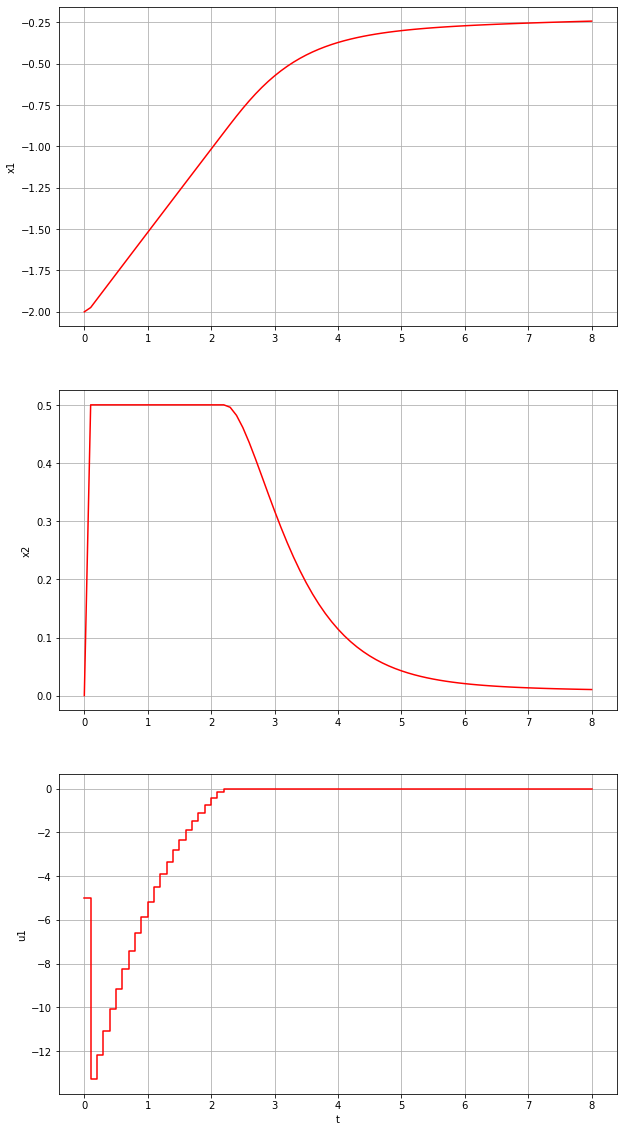

In [87]:
# Plot

# Plot the solution
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (Nx):
    plt.subplot( str(Nx + Nu) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_trajectory[i::Nx]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

for i in range(Nu):
    plt.subplot( str(Nx + Nu) + str(1) + str(Nx + i + 1) )
    plt.grid()
    u_opt = u_trajectory[i::Nu]
    plt.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), 'r')
    plt.ylabel('u' + str(i + 1))
plt.xlabel('t')
plt.show()

### Run multiple simulations

In [88]:
x_sim_list = []
u_sim_list = []

N_traj_sim = 500 # Monte carlo

for j in range(N_traj_sim):
    x_trajectory = []
    u_trajectory = []    
    theta_array = np.random.uniform(-1,1,1)

    x_init = [-2.,0.]
    nl = {}
    nl['x0'] = [0] * N_pred
    nl['lbx'] = [-ca.inf for i in range(N_pred)]
    nl['ubx'] = [ca.inf for i in range(N_pred)]
    nl['lbg'] = [-ca.inf for i in range(N_pred)]
    nl['ubg'] = [0 for i in range(N_pred)]
    # nl['p'] = [x0]

    xk = x_init
    x_trajectory = []
    x_trajectory += xk

    # Start simulation
    for i in range(N_sim):
#         print(xk)
        nl['p'] = xk
        sol = solver(**nl)
        x_opt_past = sol['x'].full().flatten()

        # Find optimal input
        opt_u = x_opt_past[:Nu].tolist()
        u_trajectory += opt_u

        # Apply the optimal input to the real system
        x_next_real = ode_dis_func(xk,opt_u,theta_array)
        x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

        # Update solver
        xk = x_next_real
        nl['x0'] = x_opt_past
    print("sim ",j, " finished")
    x_sim_list += [x_trajectory]
    u_sim_list += [u_trajectory]

sim  0  finished
sim  1  finished
sim  2  finished
sim  3  finished
sim  4  finished
sim  5  finished
sim  6  finished
sim  7  finished
sim  8  finished
sim  9  finished
sim  10  finished
sim  11  finished
sim  12  finished
sim  13  finished
sim  14  finished
sim  15  finished
sim  16  finished
sim  17  finished
sim  18  finished
sim  19  finished
sim  20  finished
sim  21  finished
sim  22  finished
sim  23  finished
sim  24  finished
sim  25  finished
sim  26  finished
sim  27  finished
sim  28  finished
sim  29  finished
sim  30  finished
sim  31  finished
sim  32  finished
sim  33  finished
sim  34  finished
sim  35  finished
sim  36  finished
sim  37  finished
sim  38  finished
sim  39  finished
sim  40  finished
sim  41  finished
sim  42  finished
sim  43  finished
sim  44  finished
sim  45  finished
sim  46  finished
sim  47  finished
sim  48  finished
sim  49  finished
sim  50  finished
sim  51  finished
sim  52  finished
sim  53  finished
sim  54  finished
sim  55  finished
si

sim  437  finished
sim  438  finished
sim  439  finished
sim  440  finished
sim  441  finished
sim  442  finished
sim  443  finished
sim  444  finished
sim  445  finished
sim  446  finished
sim  447  finished
sim  448  finished
sim  449  finished
sim  450  finished
sim  451  finished
sim  452  finished
sim  453  finished
sim  454  finished
sim  455  finished
sim  456  finished
sim  457  finished
sim  458  finished
sim  459  finished
sim  460  finished
sim  461  finished
sim  462  finished
sim  463  finished
sim  464  finished
sim  465  finished
sim  466  finished
sim  467  finished
sim  468  finished
sim  469  finished
sim  470  finished
sim  471  finished
sim  472  finished
sim  473  finished
sim  474  finished
sim  475  finished
sim  476  finished
sim  477  finished
sim  478  finished
sim  479  finished
sim  480  finished
sim  481  finished
sim  482  finished
sim  483  finished
sim  484  finished
sim  485  finished
sim  486  finished
sim  487  finished
sim  488  finished
sim  489  fi

In [89]:
x_sim_list

[[-2.0,
  0.0,
  -1.9743629711512618,
  0.49550950750131384,
  -1.9243417709766018,
  0.4955068720806251,
  -1.8743447451161226,
  0.49550157028723846,
  -1.8243713935862464,
  0.4954964103030175,
  -1.7744210790004429,
  0.4954913918718468,
  -1.7244931648255444,
  0.4954865147387084,
  -1.6745870153480347,
  0.49548177866187854,
  -1.6247019956421822,
  0.4954771833846151,
  -1.5748374715376434,
  0.4954727286905757,
  -1.5249928095881076,
  0.49546841434834854,
  -1.4751673770420013,
  0.4954642401409376,
  -1.4253605418132491,
  0.49546020585250905,
  -1.3755716724529847,
  0.49545631127772277,
  -1.3258001381244005,
  0.49545255616637207,
  -1.2760453085666703,
  0.4954489405021524,
  -1.2263065541031448,
  0.4954454633901464,
  -1.1765832455430194,
  0.49544212619840644,
  -1.1268747541916666,
  0.49543892746928797,
  -1.0771804518806944,
  0.4954358673874544,
  -1.0274997133619126,
  0.4954328975298383,
  -0.9778319087592036,
  0.49543016216093955,
  -0.928176409066275,
  0.4954

In [90]:
x2_sim = [x_traj[1::2] for x_traj in x_sim_list]
x2_sim_np = np.array(x2_sim)
x2_mean = np.mean(x2_sim_np,axis=0)

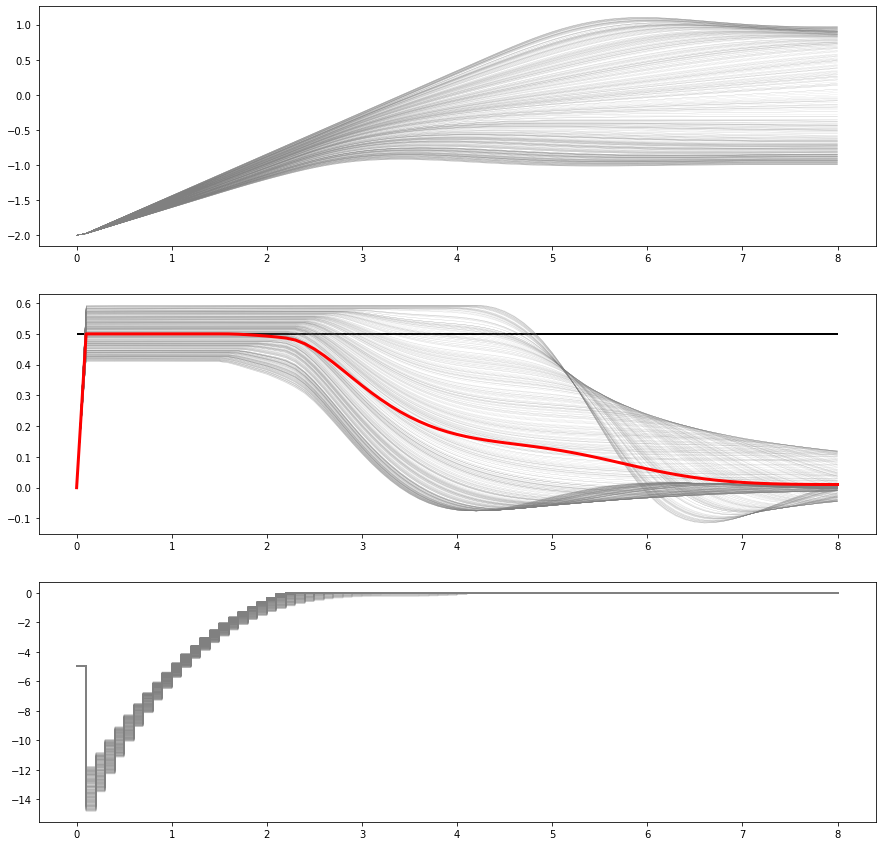

In [91]:
# Plot

# Plot the solution
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(15,15))



for j in range(len(x_sim_list)):
    x_trajectory_temp = x_sim_list[j]
    u_trajectory_temp = u_sim_list[j]
    for i in range (Nx):
#         plt.subplot( str(Nx + Nu) + str(1) + str(i + 1) )
#         plt.grid()
        x_opt = x_trajectory_temp[i::Nx]
        if i == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
#             plt.ylabel('x' + str(i + 1))
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
#             plt.ylabel('x' + str(i + 1))

    for i in range(Nu):
#         plt.subplot( str(Nx + Nu) + str(1) + str(Nx + i + 1) )
#         plt.grid()
        u_opt = u_trajectory_temp[i::Nu]
        ax3.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), 'grey',alpha=0.7,lw=0.1)
#         plt.ylabel('u' + str(i + 1))
#     plt.xlabel('t')
ax2.hlines(y=0.5, xmin=0, xmax=8, linewidth=2, color='k')
ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

### If the additive disturbance not satisfies the assumed distributinon

#### shifted distribution

In [98]:
x_sim_list = []
u_sim_list = []

N_traj_sim = 500 # Monte carlo

for j in range(N_traj_sim):
    x_trajectory = []
    u_trajectory = []    
    theta_array = np.random.uniform(-0.5,1.5,1)

    x_init = [-2.,0.]
    nl = {}
    nl['x0'] = [0] * N_pred
    nl['lbx'] = [-ca.inf for i in range(N_pred)]
    nl['ubx'] = [ca.inf for i in range(N_pred)]
    nl['lbg'] = [-ca.inf for i in range(N_pred)]
    nl['ubg'] = [0 for i in range(N_pred)]
    # nl['p'] = [x0]

    xk = x_init
    x_trajectory = []
    x_trajectory += xk

    # Start simulation
    for i in range(N_sim):
#         print(xk)
        nl['p'] = xk
        sol = solver(**nl)
        x_opt_past = sol['x'].full().flatten()

        # Find optimal input
        opt_u = x_opt_past[:Nu].tolist()
        u_trajectory += opt_u

        # Apply the optimal input to the real system
        x_next_real = ode_dis_func(xk,opt_u,theta_array)
        x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

        # Update solver
        xk = x_next_real
        nl['x0'] = x_opt_past
    print("sim ",j, " finished")
    x_sim_list += [x_trajectory]
    u_sim_list += [u_trajectory]

sim  0  finished
sim  1  finished
sim  2  finished
sim  3  finished
sim  4  finished
sim  5  finished
sim  6  finished
sim  7  finished
sim  8  finished
sim  9  finished
sim  10  finished
sim  11  finished
sim  12  finished
sim  13  finished
sim  14  finished
sim  15  finished
sim  16  finished
sim  17  finished
sim  18  finished
sim  19  finished
sim  20  finished
sim  21  finished
sim  22  finished
sim  23  finished
sim  24  finished
sim  25  finished
sim  26  finished
sim  27  finished
sim  28  finished
sim  29  finished
sim  30  finished
sim  31  finished
sim  32  finished
sim  33  finished
sim  34  finished
sim  35  finished
sim  36  finished
sim  37  finished
sim  38  finished
sim  39  finished
sim  40  finished
sim  41  finished
sim  42  finished
sim  43  finished
sim  44  finished
sim  45  finished
sim  46  finished
sim  47  finished
sim  48  finished
sim  49  finished
sim  50  finished
sim  51  finished
sim  52  finished
sim  53  finished
sim  54  finished
sim  55  finished
si

sim  437  finished
sim  438  finished
sim  439  finished
sim  440  finished
sim  441  finished
sim  442  finished
sim  443  finished
sim  444  finished
sim  445  finished
sim  446  finished
sim  447  finished
sim  448  finished
sim  449  finished
sim  450  finished
sim  451  finished
sim  452  finished
sim  453  finished
sim  454  finished
sim  455  finished
sim  456  finished
sim  457  finished
sim  458  finished
sim  459  finished
sim  460  finished
sim  461  finished
sim  462  finished
sim  463  finished
sim  464  finished
sim  465  finished
sim  466  finished
sim  467  finished
sim  468  finished
sim  469  finished
sim  470  finished
sim  471  finished
sim  472  finished
sim  473  finished
sim  474  finished
sim  475  finished
sim  476  finished
sim  477  finished
sim  478  finished
sim  479  finished
sim  480  finished
sim  481  finished
sim  482  finished
sim  483  finished
sim  484  finished
sim  485  finished
sim  486  finished
sim  487  finished
sim  488  finished
sim  489  fi

In [99]:
x2_sim = [x_traj[1::2] for x_traj in x_sim_list]
x2_sim_np = np.array(x2_sim)
x2_mean = np.mean(x2_sim_np,axis=0)

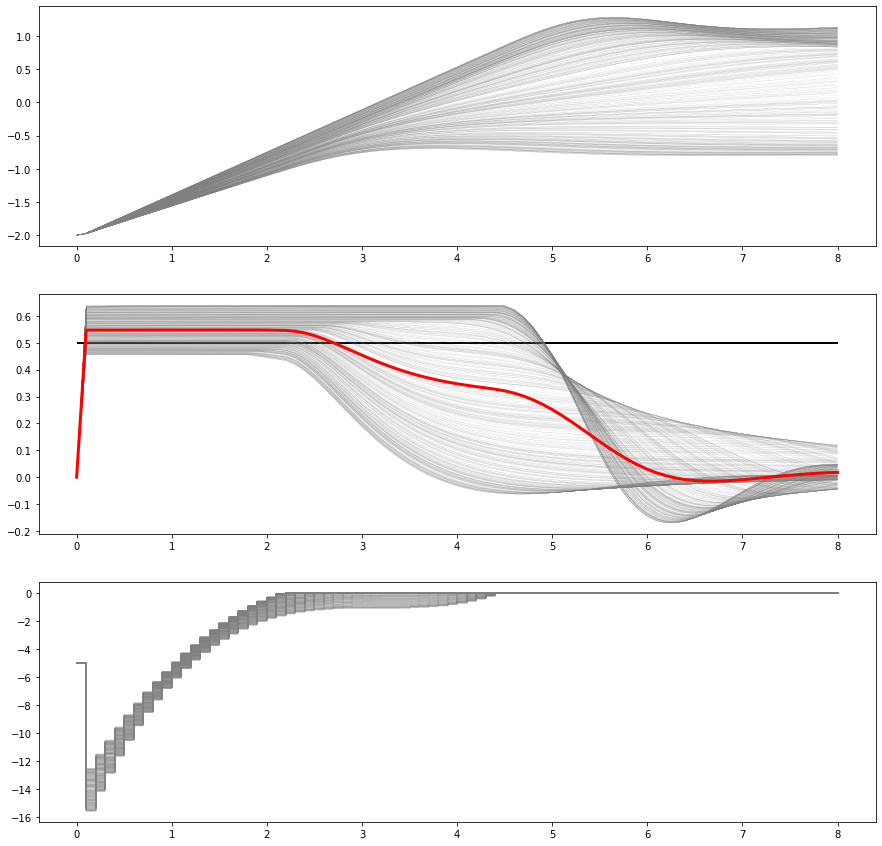

In [100]:
# Plot

# Plot the solution
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(15,15))



for j in range(len(x_sim_list)):
    x_trajectory_temp = x_sim_list[j]
    u_trajectory_temp = u_sim_list[j]
    for i in range (Nx):
#         plt.subplot( str(Nx + Nu) + str(1) + str(i + 1) )
#         plt.grid()
        x_opt = x_trajectory_temp[i::Nx]
        if i == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
#             plt.ylabel('x' + str(i + 1))
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
#             plt.ylabel('x' + str(i + 1))

    for i in range(Nu):
#         plt.subplot( str(Nx + Nu) + str(1) + str(Nx + i + 1) )
#         plt.grid()
        u_opt = u_trajectory_temp[i::Nu]
        ax3.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), 'grey',alpha=0.7,lw=0.1)
#         plt.ylabel('u' + str(i + 1))
#     plt.xlabel('t')
ax2.hlines(y=0.5, xmin=0, xmax=8, linewidth=2, color='k')
ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### scaled distribution

In [101]:
x_sim_list = []
u_sim_list = []

N_traj_sim = 500 # Monte carlo

for j in range(N_traj_sim):
    x_trajectory = []
    u_trajectory = []    
    theta_array = np.random.uniform(-1.5,1.5,1)

    x_init = [-2.,0.]
    nl = {}
    nl['x0'] = [0] * N_pred
    nl['lbx'] = [-ca.inf for i in range(N_pred)]
    nl['ubx'] = [ca.inf for i in range(N_pred)]
    nl['lbg'] = [-ca.inf for i in range(N_pred)]
    nl['ubg'] = [0 for i in range(N_pred)]
    # nl['p'] = [x0]

    xk = x_init
    x_trajectory = []
    x_trajectory += xk

    # Start simulation
    for i in range(N_sim):
#         print(xk)
        nl['p'] = xk
        sol = solver(**nl)
        x_opt_past = sol['x'].full().flatten()

        # Find optimal input
        opt_u = x_opt_past[:Nu].tolist()
        u_trajectory += opt_u

        # Apply the optimal input to the real system
        x_next_real = ode_dis_func(xk,opt_u,theta_array)
        x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

        # Update solver
        xk = x_next_real
        nl['x0'] = x_opt_past
    print("sim ",j, " finished")
    x_sim_list += [x_trajectory]
    u_sim_list += [u_trajectory]

sim  0  finished
sim  1  finished
sim  2  finished
sim  3  finished
sim  4  finished
sim  5  finished
sim  6  finished
sim  7  finished
sim  8  finished
sim  9  finished
sim  10  finished
sim  11  finished
sim  12  finished
sim  13  finished
sim  14  finished
sim  15  finished
sim  16  finished
sim  17  finished
sim  18  finished
sim  19  finished
sim  20  finished
sim  21  finished
sim  22  finished
sim  23  finished
sim  24  finished
sim  25  finished
sim  26  finished
sim  27  finished
sim  28  finished
sim  29  finished
sim  30  finished
sim  31  finished
sim  32  finished
sim  33  finished
sim  34  finished
sim  35  finished
sim  36  finished
sim  37  finished
sim  38  finished
sim  39  finished
sim  40  finished
sim  41  finished
sim  42  finished
sim  43  finished
sim  44  finished
sim  45  finished
sim  46  finished
sim  47  finished
sim  48  finished
sim  49  finished
sim  50  finished
sim  51  finished
sim  52  finished
sim  53  finished
sim  54  finished
sim  55  finished
si

sim  437  finished
sim  438  finished
sim  439  finished
sim  440  finished
sim  441  finished
sim  442  finished
sim  443  finished
sim  444  finished
sim  445  finished
sim  446  finished
sim  447  finished
sim  448  finished
sim  449  finished
sim  450  finished
sim  451  finished
sim  452  finished
sim  453  finished
sim  454  finished
sim  455  finished
sim  456  finished
sim  457  finished
sim  458  finished
sim  459  finished
sim  460  finished
sim  461  finished
sim  462  finished
sim  463  finished
sim  464  finished
sim  465  finished
sim  466  finished
sim  467  finished
sim  468  finished
sim  469  finished
sim  470  finished
sim  471  finished
sim  472  finished
sim  473  finished
sim  474  finished
sim  475  finished
sim  476  finished
sim  477  finished
sim  478  finished
sim  479  finished
sim  480  finished
sim  481  finished
sim  482  finished
sim  483  finished
sim  484  finished
sim  485  finished
sim  486  finished
sim  487  finished
sim  488  finished
sim  489  fi

In [102]:
x2_sim = [x_traj[1::2] for x_traj in x_sim_list]
x2_sim_np = np.array(x2_sim)
x2_mean = np.mean(x2_sim_np,axis=0)

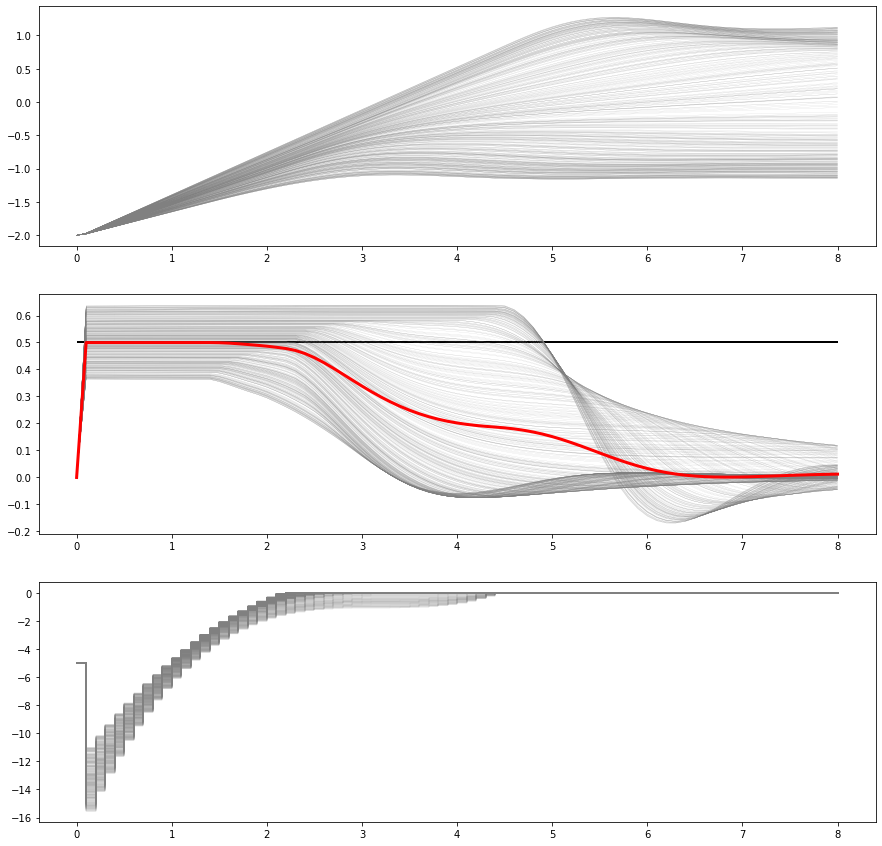

In [103]:
# Plot

# Plot the solution
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(15,15))



for j in range(len(x_sim_list)):
    x_trajectory_temp = x_sim_list[j]
    u_trajectory_temp = u_sim_list[j]
    for i in range (Nx):
#         plt.subplot( str(Nx + Nu) + str(1) + str(i + 1) )
#         plt.grid()
        x_opt = x_trajectory_temp[i::Nx]
        if i == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
#             plt.ylabel('x' + str(i + 1))
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
#             plt.ylabel('x' + str(i + 1))

    for i in range(Nu):
#         plt.subplot( str(Nx + Nu) + str(1) + str(Nx + i + 1) )
#         plt.grid()
        u_opt = u_trajectory_temp[i::Nu]
        ax3.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), 'grey',alpha=0.7,lw=0.1)
#         plt.ylabel('u' + str(i + 1))
#     plt.xlabel('t')
ax2.hlines(y=0.5, xmin=0, xmax=8, linewidth=2, color='k')
ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()